# Discovery of Writing Differences - Data Exploration

Capstone project by Tomo Umer

<img src="https://tomoumerdotcom.files.wordpress.com/2022/04/cropped-pho_logo_notext.png" alt="PRAISE DOG" style="width:400px;height:400px;"/>

## Imports

In [42]:
import pandas as pd
import numpy as np
import re
import glob
import plotly.express as px
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.neural_network import MLPClassifier, MLPRegressor
# from sklearn.preprocessing import MaxAbsScaler
# from copy import deepcopy

# import umap
# from scipy import spatial
# from scipy.cluster.hierarchy import linkage, dendrogram

## Exploring Available Books

An initial exploration of available books and what was not downloaded (but should, according to the metadata).

To start with, figure out which books were not downloaded and yet they are present in the metadata csv!

In [2]:
books_list = []

# list of books downloaded successfully into the /raw/ folder
for name in glob.glob('../data/raw/*'):
    books_list.append(re.findall(r'PG\d*', name)[0])

# the metadata (books that should be there)
library = pd.read_csv('../data/metadata.csv')

# the difference
len(library) - len(books_list)

3435

There are 3435 "books" listed in the metadata that did not get downloaded.

In [3]:
missing_library = library.loc[~library['id'].isin(books_list)]

print(missing_library['type'].value_counts(dropna=False))
print('\nEnglish missing only:')
print(missing_library.loc[missing_library['language'].str.find('en') > -1]['type'].value_counts(dropna=False))

NaN            2215
Sound          1104
Dataset          83
Image            33
MovingImage       7
StillImage        3
Collection        1
Text              1
Name: type, dtype: int64

English missing only:
NaN            1991
Sound          1039
Dataset          83
Image            33
MovingImage       7
StillImage        3
Collection        1
Text              1
Name: type, dtype: int64


Initially, I filtered them one by one and explored the contents. For the sake of keeping the notebook cleaner, I decided to compact the code below, to display (up to) five rows for each category:

- 'NaNs' are the actual books; so I am missing 2215 of them in my local library. If I get the time I'd like to explore why they did not get downloaded
- 'Sounds' are fequently transcriptions of speeches. Not interested in those.
- 'Datasets' are primarily Human Genome Project (72 of them). There are 10 calculations of square roots and 1/pi to a million digits. 'Moby Word Lists' is just info on gutenberg, disclaimers, etc...
- the 'Image' contains music sheets
- 'MovingImage' contains comets video, rotating earth and 5 nuclear test videos
- 'StillImages' contain a kids story illustrated and two maps/ map images
- 'Collection' contains 'Project Gutenberg DVD: The July 2006 Special' and the only not downloaded text is just empty.
- And then there is 'text' which I'm sure it was supposed to be for books, but it's just NaNs all around

In [4]:
# get a list of the file types (note: it's the same as in the full library)
file_types = missing_library['type'].unique()

# loop over the list and display dataframes belonging to those 8 different types
for file_type in file_types:
    filtered_library = missing_library.loc[missing_library['type'].isna() if file_type is np.nan
                                           else missing_library['type'] == file_type]
    display(filtered_library.head())


,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
151,PG10137,Mary Had a Little Lamb: Recording taken from M...,"Edison, Thomas A. (Thomas Alva)",1847.0,1931.0,['en'],21,"{'Nursery rhymes, American'}",Sound
168,PG10152,Voice Trial - Kinetophone actor audition,"Lett, Bob",NaN,NaN,['en'],4,{'Auditions'},Sound
169,PG10153,Voice Trial - Kinetophone Actor Audition,"Lenord, Frank",NaN,NaN,['en'],4,{'Auditions'},Sound
170,PG10154,Voice Trial - Kinetophone Actor Audition,"Schultz, Siegfried Von",NaN,NaN,['en'],0,{'Auditions'},Sound
171,PG10155,The Right of the People to Rule,"Roosevelt, Theodore",1858.0,1919.0,['en'],9,"{'Progressivism (United States politics)', 'Po...",Sound


,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
606,PG10547,Topsy-Turvy,"Verne, Jules",1828.0,1905.0,['en'],126,"{'Science fiction, French -- Translations into...",NaN
703,PG10634,"The Queen of Hearts, and Sing a Song for Sixpence","Caldecott, Randolph",1846.0,1886.0,['en'],44,"{'Picture books for children', 'Nursery rhymes...",NaN
841,PG10762,Impressions of Theophrastus Such,"Eliot, George",1819.0,1880.0,['en'],110,"{'Authors -- Fiction', 'England -- Fiction', '...",NaN
923,PG10836,The Algebra of Logic,"Couturat, Louis",1868.0,1914.0,['en'],97,"{'Logic, Symbolic and mathematical', 'Algebrai...",NaN
1106,PG10,The King James Version of the Bible,NaN,NaN,NaN,['en'],5831,{'Bible'},NaN


,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
1108,PG11001,String Quartet No. 05 in A major Opus 18,"Beethoven, Ludwig van",1770.0,1827.0,['en'],5,"{'Music', 'String quartets -- Scores'}",Image
1109,PG11002,"String Quartet No. 11 in F minor Opus 95 ""Seri...","Beethoven, Ludwig van",1770.0,1827.0,['en'],6,"{'String quartets -- Scores', 'Music'}",Image
1944,PG11755,String Quartet No. 10 in E flat major Opus 74 ...,"Beethoven, Ludwig van",1770.0,1827.0,['en'],15,"{'Music', 'String quartets -- Scores'}",Image
2381,PG12149,String Quartet No. 03 in D major Opus 18,"Beethoven, Ludwig van",1770.0,1827.0,['en'],15,"{'String quartets -- Scores', 'Music'}",Image
2479,PG12237,String Quartet No. 16 in F major Opus 135,"Beethoven, Ludwig van",1770.0,1827.0,['en'],21,"{'Music', 'String quartets -- Scores'}",Image


,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
1661,PG114,The Tenniel Illustrations for Carroll's Alice ...,"Tenniel, John",1820.0,1914.0,['en'],391,"{""Children's stories"", 'Fantasy fiction'}",StillImage
15515,PG239,Radar Map of the United States,United States,NaN,NaN,['en'],27,{'United States -- Maps'},StillImage
67797,PG758,"LandSat Picture of Washington, DC",United States. National Aeronautics and Space ...,NaN,NaN,['en'],36,{'Washington (D.C.) -- Remote-sensing images'},StillImage


,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
1966,PG11775,"Human Genome Project, Build 34, Chromosome Num...",Human Genome Project,NaN,NaN,['en'],37,{'Nucleotide sequence'},Dataset
1967,PG11776,"Human Genome Project, Build 34, Chromosome Num...",Human Genome Project,NaN,NaN,['en'],6,{'Nucleotide sequence'},Dataset
1968,PG11777,"Human Genome Project, Build 34, Chromosome Num...",Human Genome Project,NaN,NaN,['en'],2,{'Nucleotide sequence'},Dataset
1969,PG11778,"Human Genome Project, Build 34, Chromosome Num...",Human Genome Project,NaN,NaN,['en'],3,{'Nucleotide sequence'},Dataset
1970,PG11779,"Human Genome Project, Build 34, Chromosome Num...",Human Genome Project,NaN,NaN,['en'],1,{'Nucleotide sequence'},Dataset


,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
3416,PG13082,"Images of Comet Wild 2, Taken by NASA's Stardu...",United States. National Aeronautics and Space ...,NaN,NaN,['en'],38,{'Comets'},MovingImage
17404,PG256,Motion Picture of Rotating Earth,United States,NaN,NaN,['en'],41,{'World maps'},MovingImage
46756,PG5212,Film: Trinity Shot (first US Atomic Test),NaN,NaN,NaN,['en'],26,"{'Nuclear weapons -- Testing', 'Manhattan Proj...",MovingImage
46767,PG5213,Film: the Bikini Island ABLE Atomic Test,NaN,NaN,NaN,['en'],17,{'Nuclear weapons -- Marshall Islands -- Bikin...,MovingImage
46778,PG5214,Film: the Bikini Island BAKER Atomic Test,NaN,NaN,NaN,['en'],15,{'Nuclear weapons -- Marshall Islands -- Bikin...,MovingImage


,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
10150,PG19159,Project Gutenberg DVD: The July 2006 Special,NaN,NaN,NaN,['en'],73,set(),Collection


,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
69464,PG90907,NaN,NaN,NaN,NaN,['en'],1,set(),Text


In [5]:
# to find specific authors
# library.loc[library['author'].str.find('Lovecraft') > -1]

## Selecting (usable) English books

Filtering down to just books (removing other file types) and then specifically focussing on English books only.

This part is done in three steps, starting from the metadata "library":
1. Select books, i.e., "type" being NaN (see exploration above)
2. Select just only works makred as "English"
3. Select works that have actually been downloaded

In [6]:
print('Full Collection:', len(library))

library_en = library.loc[library['type'].isna()]

print('Books Only:', len(library_en))

library_en = library_en.loc[library_en['language'].str.find('en') > -1]

print('English Books:', len(library_en))

library_en = library_en.loc[library_en['id'].isin(books_list)]

print('Downloaded English Books:', len(library_en))

Full Collection: 70449
Books Only: 69197
English Books: 55767
Downloaded English Books: 53776


Furthermore, it may be worth considering that the vast majority of books haas less than 100 downloads in the last 30 days.

In [7]:
print(library_en[library_en['downloads'] <= 10].shape[0])
print(library_en[library_en['downloads'] <= 100].shape[0])
print(library_en[library_en['downloads'] <= 1000].shape[0])

6345
46562
53138


## Selecting Book Authors

Choosing authors to use for further analysis. Given memory (and time) constraints, I will need to limit this analysis to a few select authors. 

Grouping by author, I noticed that there's 117 titles by "unknown" author, 601 "anonymous" and 3422 "various". Upon further inspection of Various, they are majority "periodicals", meaning various magazines and so I decided it was safe to remove that.
`library_en[library_en['author'] == 'Various']['subjects'].value_counts().head(20)`

As for unknown and anonymous, those might be interesting to check once I have a model, but as is, since I'm looking for writing style, I do want to know who the author is.The umbrella of anonymous might have too many different authors within (lol at Happy and Gay Marching Away - children's poetry by Unknown author).

In [8]:
library_en.groupby('author')[['title']].count().sort_values(by='title', ascending=False).head(10)

,title
author,
Various,3422
Anonymous,601
"Shakespeare, William",178
"Ebers, Georg",163
"Parker, Gilbert",132
"Oliphant, Mrs. (Margaret)",132
"Kingston, William Henry Giles",132
"Twain, Mark",128
"Fenn, George Manville",128


In [9]:
library_en = library_en[~library_en['author'].isin(['Anonymous', 'Unknown', 'Various'])]

print('Downloaded English Books by known authors:', len(library_en))

Downloaded English Books by known authors: 49636


Ideas for selecting authors:
- first I started with top 6 based on the total # of books written to make sure my logic works
    - used `library_en.groupby('author')['title'].count().sort_values(ascending=False).head(6).index.to_list()`

Other possible options included:
- most downloads over last 30 days
- at least 1000 downloads over last 30 days
- select based on the century
- personal preference

I went back and forth on this a lot and rewrote a bunch of code, including various selects and eliminations. Current approach is to get authors by century, make sure they have at least 5 books written and limit to 70 most popular if they have more (to reduce class imbalance), as well as make sure I know of the author.

In [10]:
# function to calculate century of living, taking int account both birth and death years where possible
def calc_century(birth, death):

    if np.isnan(birth) & np.isnan(death):
        x = np.NaN
        return x

    elif np.isnan(birth):
        x = death
    elif np.isnan(death):
        x = birth
    else:
        x = (birth + (death/2 - birth/2))

    # adjust for how centuries are calculated; the first +1 adjusts for the shift of one year, because year 0 is skipped
    # and then the // 100 + 1 adjusts for the correct century, e.g. 19th is 1901 - 2000
    if x >= 0:
        x = (x - 1) // 100 + 1

    # the same logic from above is not needed for years before 0
    else:
        x = x // 100 

    return int(x)

In [11]:
# function to convert the numeric int representation of century to ordinal, plus appending BCE or CE
def annotate_century(num_century):

    if np.isnan(num_century):
        return 'unknown'
    elif int(num_century) < 0 :
        ctry = ' century BCE'
        num_century = abs(int(num_century))
    else:
        num_century = int(num_century)
        ctry = ' century CE'


    # determine ordinal numbering
    if (num_century % 10 == 1) and (num_century % 100 != 11):
        ordinal_century = str(num_century) + 'st'

    elif (num_century % 10 == 2) and (num_century % 100 != 12):
        ordinal_century = str(num_century) + 'nd'

    elif (num_century % 10 == 3) and (num_century % 100 != 13):
        ordinal_century = str(num_century) + 'rd'
        
    else:
        ordinal_century = str(num_century) + 'th'

    return ordinal_century + ctry

In [12]:
library_en['authorcentury'] = library_en.apply(lambda x: calc_century(x.authoryearofbirth, x.authoryearofdeath), axis=1)

Here's a breakdown of number authors per century. Most of them are of course concentrated in the 19th or 20th century, plus the unknown. History is written by the victors.

In [13]:
authors_by_century = library_en.groupby('authorcentury', dropna=False)[['author']].nunique().reset_index()

authors_by_century['authorcentury'] = authors_by_century['authorcentury'].apply(annotate_century)

display(authors_by_century)

,authorcentury,author
0,7th century BCE,1
1,6th century BCE,1
2,5th century BCE,8
3,4th century BCE,6
4,3rd century BCE,2
5,2nd century BCE,1
6,1st century BCE,9
7,1st century CE,9
8,2nd century CE,2
9,3rd century CE,3


The next few blocks of code are various explorations into the numbers by authors. Like stated before, I ultimately decided for a personalized approach. Will keep the blocks here for reference:

In [14]:
# authors with more than 1000 downloads over last 30 days
(
library_en.loc[library_en['downloads'] > 1000]
    .groupby('author')[['title','authorcentury']]
    .agg({'title':'count', 'authorcentury':'max'})
    .sort_values(by='title', ascending=False)
    .head(20)
)

,title,authorcentury
author,,
"Dickens, Charles",12,19.0
"Shakespeare, William",12,16.0
"Doyle, Arthur Conan",10,19.0
"Nietzsche, Friedrich Wilhelm",9,19.0
"Twain, Mark",9,19.0
Plato,8,-4.0
"Christie, Agatha",8,20.0
"Austen, Jane",8,18.0
"Wilde, Oscar",7,19.0


In [15]:
# authors based on number of downloads overall
display(library_en.sort_values(by='downloads', ascending=False).head())

display(library_en.groupby('author')[['downloads','authorcentury']].agg({'downloads':'sum', 'authorcentury':'max'}).sort_values(by='downloads', ascending=False).head())

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type,authorcentury
5702,PG1513,Romeo and Juliet,"Shakespeare, William",1564.0,1616.0,['en'],166112,"{'Juliet (Fictitious character) -- Drama', 'Ro...",NaN,16.0
18200,PG2641,A Room with a View,"Forster, E. M. (Edward Morgan)",1879.0,1970.0,['en'],145035,"{'British -- Italy -- Fiction', 'Florence (Ita...",NaN,20.0
30065,PG37106,"Little Women; Or, Meg, Jo, Beth, and Amy","Alcott, Louisa May",1832.0,1888.0,['en'],139345,"{'Bildungsromans', 'March family (Fictitious c...",NaN,19.0
5102,PG145,Middlemarch,"Eliot, George",1819.0,1880.0,['en'],138208,"{'Bildungsromans', 'Married people -- Fiction'...",NaN,19.0
18867,PG2701,"Moby Dick; Or, The Whale","Melville, Herman",1819.0,1891.0,['en'],135040,"{'Whaling -- Fiction', 'Psychological fiction'...",NaN,19.0


,downloads,authorcentury
author,,
"Smollett, T. (Tobias)",364524,18.0
"Shakespeare, William",333424,16.0
"Alcott, Louisa May",154321,19.0
"Forster, E. M. (Edward Morgan)",150394,20.0
"Eliot, George",145394,19.0


In [16]:
# same as above, but by century if interested in that
# cte = 19

# display(library_en.loc[library_en['authorcentury'] == cte].groupby('author')[['title']].count().sort_values(by='title',ascending=False).head()) #
# display(library_en.loc[library_en['authorcentury'] == cte].groupby('author')[['downloads']].sum().sort_values(by='downloads',ascending=False).head())

Finally, my approach to chosing the authors (ended up with 22), was an iterative process. This was my initial setup:
```    
        library_en
        .loc[(library_en['author'].isin(select_authors)) | (library_en['authorcentury'] >= -7.)]
        .groupby('author')
        .agg({'authorcentury': 'max', 'title':'count', 'downloads': 'max'})
        .sort_values(by=['authorcentury', 'title', 'downloads'], ascending=[True, False, False])
        .head(30)
```
The authors list was empty and for the century essentially I picked all (no books are older than 7th BCE). Afterwards it was an iterative process:
1. for each century, pick at an author with at least 5 books that I recognize (if possible)
2. add the author to the select_authors list, and increase the authorcentury filter by 1
3. note: for later centuries I started picking more authors
4. make any adjustments to authors names or cut down # of books if too many

In [17]:
# changed the name to pull together Plato and Shakespeare
library_en = library_en.replace({'author': {'Plato (spurious and doubtful works)': 'Plato'}})
library_en = library_en.replace({'author': {'Shakespeare (spurious and doubtful works)': 'Shakespeare, William'}})

In [18]:
# I was listing all the authors to remove and that list grew waay too big ... instead will build it with select

# possibly Virgil instead of Cicero, Marcus Tullius 
# possibly change seneca
# possibly keep Plotinus, for 2nd century philosophy
# Omar Khayyam only possible candidate for 10th ?
# giovanni bocaccio may need to be replaced by petrarca francesco
select_authors = [
    'Homer',
    'Confucius',
    'Plato',
    'Cicero, Marcus Tullius',
    'Seneca, Lucius Annaeus',
    'Marcus Aurelius, Emperor of Rome',
    'Dante Alighieri',
    'Boccaccio, Giovanni',
    'Machiavelli, Niccolò',
    'Shakespeare, William',
    'Molière',
    'Defoe, Daniel',
    'Jefferson, Thomas', # maybe maybe not,
    'Austen, Jane',
    'Twain, Mark',
    'Dickens, Charles',
    'Doyle, Arthur Conan',
    'Dumas, Alexandre',
    'Churchill, Winston',
    'Dick, Philip K.',
    'Huxley, Aldous',
    'Lovecraft, H. P. (Howard Phillips)'
]

In [19]:
len(select_authors)

22

In [20]:
(
    library_en
        .loc[(library_en['author'].isin(select_authors)) | (library_en['authorcentury'] >= 22.)]
        .groupby('author')
        .agg({'authorcentury': 'max', 'title':'count', 'downloads': 'max'})
        .sort_values(by=['authorcentury', 'title', 'downloads'], ascending=[True, False, False])
        .head(30)
        #.tail(10)
)

,authorcentury,title,downloads
author,,,
Homer,-7.0,14,11357
Confucius,-6.0,5,469
Plato,-4.0,33,8046
"Cicero, Marcus Tullius",-1.0,14,1103
"Seneca, Lucius Annaeus",1.0,7,590
"Marcus Aurelius, Emperor of Rome",2.0,5,6999
Dante Alighieri,13.0,19,6896
"Boccaccio, Giovanni",14.0,6,2695
"Machiavelli, Niccolò",15.0,5,12776


In [21]:
# this was to see individual authors and thier most popular works
library_en.loc[library_en['author'] == 'Shakespeare, William'].sort_values(by='downloads', ascending=False).head(10)

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type,authorcentury
5702,PG1513,Romeo and Juliet,"Shakespeare, William",1564.0,1616.0,['en'],166112,"{'Juliet (Fictitious character) -- Drama', 'Ro...",NaN,16.0
110,PG100,The Complete Works of William Shakespeare,"Shakespeare, William",1564.0,1616.0,['en'],124452,{'English drama -- Early modern and Elizabetha...,NaN,16.0
14452,PG23042,The Tempest: The Works of William Shakespeare ...,"Shakespeare, William",1564.0,1616.0,['en'],6820,"{'Spirits -- Drama', 'Tragicomedy', 'Shipwreck...",NaN,16.0
5824,PG1524,"Hamlet, Prince of Denmark","Shakespeare, William",1564.0,1616.0,['en'],4015,"{'Kings and rulers -- Succession -- Drama', 'H...",NaN,16.0
19689,PG27761,"Hamlet, Prince of Denmark","Shakespeare, William",1564.0,1616.0,['en'],3638,"{'Kings and rulers -- Succession -- Drama', 'H...",NaN,16.0
5924,PG1533,Macbeth,"Shakespeare, William",1564.0,1616.0,['en'],2911,"{'Scotland -- Kings and rulers -- Drama', 'Reg...",NaN,16.0
1250,PG1112,The Tragedy of Romeo and Juliet,"Shakespeare, William",1564.0,1616.0,['en'],1512,"{'Juliet (Fictitious character) -- Drama', 'Ro...",NaN,16.0
5902,PG1531,"Othello, the Moor of Venice","Shakespeare, William",1564.0,1616.0,['en'],1443,"{'Jealousy -- Drama', 'Interracial marriage --...",NaN,16.0
5713,PG1514,A Midsummer Night's Dream,"Shakespeare, William",1564.0,1616.0,['en'],1399,"{'Fairy plays', 'Courtship -- Drama', 'Athens ...",NaN,16.0
5724,PG1515,The Merchant of Venice,"Shakespeare, William",1564.0,1616.0,['en'],1159,"{'Venice (Italy) -- Drama', 'Jews -- Italy -- ...",NaN,16.0


In [22]:
# to check/open individual books when needed
# book_id = 'PG65972'
# with open(f'../data/raw/{book_id}_raw.txt', encoding = 'utf-8') as fi:
#              book = fi.read()

# len(book)

In [23]:
# this is to count the books in order based on descending popularity; +1 is there to start the count at 1 and not 0
# note: I could also sort them randomly
library_en['book_count'] =  (
     library_en
        .sort_values("downloads", ascending=False)
        .groupby('author')
        .cumcount() + 1
)

In [24]:
# get the authors that I selected above
library_select = library_en.loc[(library_en['author'].isin(select_authors))]

# for authors with more than 70 books, filter it down to 70
library_select = library_select.loc[library_select['book_count'] <= 70.]

In [25]:
# for authors with too many books, randomly generate 100 of his books to remove, leaving 88; might decide to remove from top or bottom based on popularity
# old code
# rm_shakespeare = library_en.loc[library_en['author'] == 'Shakespeare, William'].sample(n=100, replace=False, random_state=42)['id']

# similar to shakespeare, leaving 88
# rm_twain = library_en.loc[library_en['author'] == 'Twain, Mark'].sample(n=40, replace=False, random_state=42)['id']

# library_select = library_en[(library_en['author'].isin(select_authors))
#                             & (~library_en['id'].isin(rm_shakespeare))
#                             & (~library_en['id'].isin(rm_twain))]

## Reading Book Contents

Code to read in the actual texts (from library_select)

Function that opens files and extracts the text (leaving the Gutenberg info at top and bottom out).

In [26]:
def import_book(filepath):
    
    try:
        with open(filepath, encoding = 'utf-8') as fi:
            book = fi.read()

    except:
        # note: when using this, the weird characters, such as ì get left out!
        with open(filepath, encoding = 'unicode_escape') as fi:
            book = fi.read()

    if(not re.search('\*\*\* START OF .+? \*\*\*', book)):
        book_start = 0
    else:
        book_start = re.search('\*\*\* START OF .+? \*\*\*', book).end()

    if(not re.search('\*\*\* END OF .+? \*\*\*', book)):
        book_end = -1
    else:
        book_end = re.search('\*\*\* END OF .+? \*\*\*', book).start()

    book = book[book_start : book_end]

    return book

Process the selected authors books and save their texts into library_select:

In [27]:
for book_id in library_select['id']:
    
    filepath = f'../data/raw/{book_id}_raw.txt'

    try:
        book = import_book(filepath)

        library_select.loc[library_select['id'] == book_id, 'book_content'] = book
        
    except:
        print('could not open', filepath)

        library_select.loc[library_select['id'] == book_id, 'book_content'] = 'could not open'

    

In [28]:
# there are some books who had weird characters and were not able to open; fixed that
library_unopened_books = library_select.loc[library_select['book_content'] == 'could not open']
print('could not open:', library_unopened_books.shape)

library_select = library_select.loc[library_select['book_content'] != 'could not open']
print('shape of library_select:', library_select.shape)

could not open: (0, 12)
shape of library_select: (651, 12)


In [ ]:
# to see more in a column of df; set 50 to None to display all
# pd.set_option('display.max_colwidth', 50) 

In [29]:
#library_select.to_pickle('../data/library_select01.pkl')

## Testing with LogReg

This part does not need to be run (and therefore it is commented). Testing purposes only.

In [30]:
# # dictionary of
# authors_to_num = {select_authors[i]: i for i in range(len(select_authors))}

# library_select = library_select.replace({'author': authors_to_num})

# # to invert the above
# num_to_authors = {v: k for k, v in authors_to_num.items()}

In [31]:
# authors_to_num

{'Homer': 0,
 'Confucius': 1,
 'Plato': 2,
 'Cicero, Marcus Tullius': 3,
 'Seneca, Lucius Annaeus': 4,
 'Marcus Aurelius, Emperor of Rome': 5,
 'Dante Alighieri': 6,
 'Boccaccio, Giovanni': 7,
 'Machiavelli, Niccolò': 8,
 'Shakespeare, William': 9,
 'Molière': 10,
 'Defoe, Daniel': 11,
 'Jefferson, Thomas': 12,
 'Austen, Jane': 13,
 'Twain, Mark': 14,
 'Dickens, Charles': 15,
 'Doyle, Arthur Conan': 16,
 'Dumas, Alexandre': 17,
 'Churchill, Winston': 18,
 'Dick, Philip K.': 19,
 'Huxley, Aldous': 20,
 'Lovecraft, H. P. (Howard Phillips)': 21}

In [32]:
# X = library_select[['book_content']]
# y = library_select['author']

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [33]:
# print(X_train.shape)

# print(X_test.shape)

(488, 1)
(163, 1)


In [34]:
# pipe_logreg = Pipeline(
#     steps = [
#         ('vect', TfidfVectorizer(min_df=2, max_df=0.8, ngram_range=(1,2))),
#         ('logreg', LogisticRegression(max_iter = 10000))
#     ]
# )

In [35]:
# pipe_logreg.fit(X_train['book_content'], y_train)
# y_pred = pipe_logreg.predict(X_test['book_content'])

# print('accuracy score:', accuracy_score(y_test, y_pred), '\n')
# print('---- confusion matrix ------')
# print(confusion_matrix(y_test, y_pred), '\n')
# print('-------- classification report ---------')
# print(classification_report(y_test, y_pred))

accuracy score: 0.7852760736196319 

---- confusion matrix ------
[[ 2  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  3  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0

/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
# fig = px.imshow(confusion_matrix(y_test, y_pred),
#                 width=1000,
#                 height=800,
#                 text_auto=True,
#                 labels=dict(x="Predicted Label",
#                             y="True Label"),
#                             x=tuple(authors_to_num.keys()),
#                             y=tuple(authors_to_num.keys()),
#                             color_continuous_scale='Teal'
#                             )

# fig.update(layout_coloraxis_showscale=False)

# fig.show()

In [ ]:
## pipe_logreg['vect'].vocabulary_['î']

# {k:v for (k,v) in pipe_logreg['vect'].vocabulary_.items() if v < 100}

To test out my logic, let's see how my own two books measure up!

In [37]:
# my_books = pd.DataFrame()

# for book_name in ('Deathway', 'Lambda'):
#         filepath = f'../data/{book_name} by Tomo Umer.txt'

#         with open(filepath, encoding = 'utf-8') as fi:
#                 book = fi.read()
        
#         tmp_book = pd.DataFrame({'author': 'Umer, Tomo', 'title': [book_name], 'book_content': [book]})

#         my_books = pd.concat([my_books, tmp_book], ignore_index = True)

In [38]:
# pipe_logreg.predict_proba(my_books['book_content'])

array([[0.01963602, 0.0100785 , 0.03989145, 0.0226394 , 0.0120409 ,
        0.00939012, 0.02137647, 0.01181939, 0.01006743, 0.06986171,
        0.03240526, 0.06026573, 0.02139153, 0.02858198, 0.15240591,
        0.08705393, 0.10671567, 0.09747233, 0.10807764, 0.03636318,
        0.02565156, 0.01681391],
       [0.01831437, 0.00908287, 0.03338067, 0.02032388, 0.01147422,
        0.00861281, 0.01941812, 0.01074654, 0.00937859, 0.04410456,
        0.02611377, 0.05346753, 0.0199214 , 0.02352118, 0.19562366,
        0.0792841 , 0.13909651, 0.09462172, 0.10154841, 0.04111203,
        0.02513155, 0.01572151]])

It would appear both of my books are most similar to Mark Twain!

In [39]:
# pd.DataFrame(pipe_logreg.predict_proba(my_books['book_content']),columns=authors_to_num.keys())

,Homer,Confucius,Plato,"Cicero, Marcus Tullius","Seneca, Lucius Annaeus","Marcus Aurelius, Emperor of Rome",Dante Alighieri,"Boccaccio, Giovanni","Machiavelli, Niccolò","Shakespeare, William",...,"Jefferson, Thomas","Austen, Jane","Twain, Mark","Dickens, Charles","Doyle, Arthur Conan","Dumas, Alexandre","Churchill, Winston","Dick, Philip K.","Huxley, Aldous","Lovecraft, H. P. (Howard Phillips)"
0,0.019636,0.010079,0.039891,0.022639,0.012041,0.009390,0.021376,0.011819,0.010067,0.069862,...,0.021392,0.028582,0.152406,0.087054,0.106716,0.097472,0.108078,0.036363,0.025652,0.016814
1,0.018314,0.009083,0.033381,0.020324,0.011474,0.008613,0.019418,0.010747,0.009379,0.044105,...,0.019921,0.023521,0.195624,0.079284,0.139097,0.094622,0.101548,0.041112,0.025132,0.015722


In [40]:
# test_df = pd.DataFrame(pipe_logreg.predict_proba(my_books['book_content']).T, columns=['Deathway', 'Lambda'])

# test_df.insert (0, 'Authors', authors_to_num.keys())

# test_df

,Authors,Deathway,Lambda
0,Homer,0.019636,0.018314
1,Confucius,0.010079,0.009083
2,Plato,0.039891,0.033381
3,"Cicero, Marcus Tullius",0.022639,0.020324
4,"Seneca, Lucius Annaeus",0.012041,0.011474
5,"Marcus Aurelius, Emperor of Rome",0.009390,0.008613
6,Dante Alighieri,0.021376,0.019418
7,"Boccaccio, Giovanni",0.011819,0.010747
8,"Machiavelli, Niccolò",0.010067,0.009379
9,"Shakespeare, William",0.069862,0.044105


## Cosine Similarity

Another way to look at the produced weights and which ones are similar

Calculating cosine similarity - for a first attempt, group it by author.

In [56]:
library_select_grouped = library_select_vec.drop(columns=['title']).groupby('author').mean()

In [57]:
dists = spatial.distance.pdist(library_select_grouped.values, metric = 'cosine')

example to calculate the dist between phillip k dick and lovecradt, need to get the correct index for dist.

Position in daataframe: 3 phillip k dick, 7 lovecraft

for i < j < m:

m * i + j - ((i + 2) * (i + 1)) // 2


In [58]:
15 * 3 + 7 - ((3+2) * (3+1)) // 2

42

In [59]:
#dists[42]

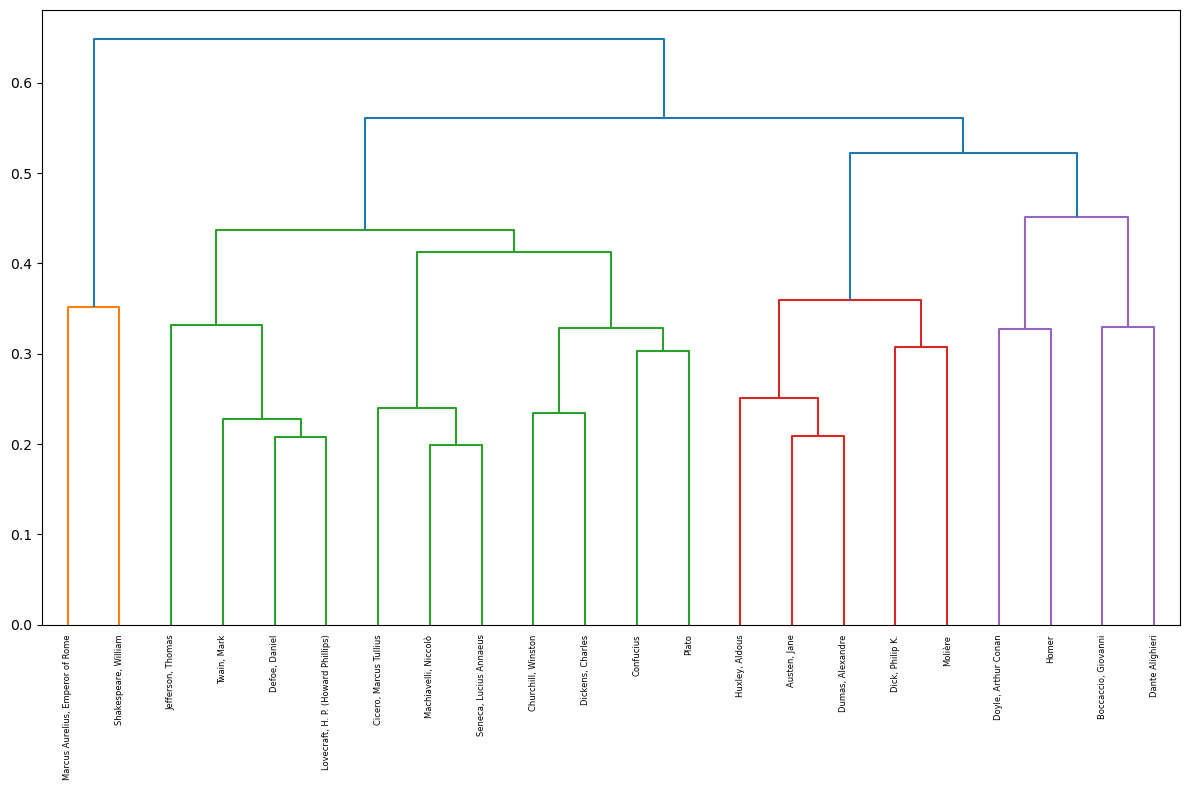

In [60]:
mergings = linkage(dists, method='complete')

plt.figure(figsize = (12,8))
dendrogram(mergings,
           labels = list(library_select_grouped.index),
           leaf_rotation = 90,
           leaf_font_size = 6);

plt.tight_layout()
#plt.savefig('images/dendogram_complete_cosine.png', transparent=False, facecolor='white', dpi = 150);

In [61]:
# this is a bit convoluted, but .. I first concatenate all the texts in the pandas series which returns an extremely long string
# I then turn that string into a pandas series (the predict requires an iterable object)
# pipe_nn_encoder.predict(pd.Series(library_top_six.loc[library_top_six['author'] == 0]['book_content'].str.cat()))

## Introducing New Text

In [62]:
my_books

,author,title,book_content
0,"Umer, Tomo",Deathway,DeathwayIndex\nIntroduction\nMy second novel! ...
1,"Umer, Tomo",Lambda,Lambda\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...


In [63]:
new_texts = pipe_nn_encoder.predict(my_books['book_content'])

In [64]:
# can I do it like this or do I need to add it before?
umap_projection_new = umap_mnist.transform(new_texts)

In [65]:
# add the new text(s)
umap_projection_new = np.concatenate((umap_projection, umap_projection_new), 0)

In [66]:
#plt.figure(figsize = (16,8))
#palette = sns.color_palette("viridis", 16) #sns.color_palette("Paired")
#sns.scatterplot(x=umap_projection_new[:,0], y=umap_projection_new[:,1], 
#                hue = pd.concat([library_select.replace({'author': num_to_authors})['author'], my_books['author']]).astype('category'),
#                #palette=palette,
#               alpha = 0.7);

In [67]:
library_select_proj = pd.DataFrame(umap_projection_new, columns=[f'proj_{x}' for x in range(2)])

In [68]:
library_select_new = pd.concat([library_select.replace({'author': num_to_authors})[['title','author']], my_books[['title', 'author']]])

In [69]:
library_select_proj = pd.concat([library_select_new,
                                 library_select_proj.set_index(library_select_new.index)], axis=1)

In [70]:
library_select_proj

,title,author,proj_0,proj_1
1,Apocolocyntosis,"Seneca, Lucius Annaeus",6.723675,7.191339
6,La Fiammetta,"Boccaccio, Giovanni",5.590945,8.721720
21,"Divine Comedy, Longfellow's Translation, Hell",Dante Alighieri,5.171262,5.667461
32,"Divine Comedy, Longfellow's Translation, Purga...",Dante Alighieri,5.179149,5.687298
43,"Divine Comedy, Longfellow's Translation, Paradise",Dante Alighieri,5.378969,5.793653
...,...,...,...,...
70091,Nicholas Nickleby,"Dickens, Charles",9.260446,6.998053
70102,Martin Chuzzlewit,"Dickens, Charles",9.428117,7.256976
70269,"Tour through the Eastern Counties of England, ...","Defoe, Daniel",6.606389,1.534494
0,Deathway,"Umer, Tomo",7.034669,8.214521


In [71]:
fig = px.scatter(data_frame = library_select_proj,
                 x='proj_0',
                 y='proj_1',
                 width=1200,
                 height=800,
                 color= 'author',
                 hover_data= ['title']
                 )

fig.show()